In [1]:
import numpy as np
from trajectories import *
from guided_ot import *
from simplicial_paths import *
import networkx as nx 

In [2]:
def plot_bases(SC):
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    for i in range(SC.H_extra.shape[0]):
        print(SC.H_extra.shape)
        harm_vec = SC.H_extra[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        G = SC.graph
        GG = nx.DiGraph()
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            #print(edge, edge_sign, oriented_edge)
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            GG.add_edge(edge[0], edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight'] for u,v in G_oriented.edges]

        plt.figure(figsize=(6,6))
        nx.draw(G_oriented, pos=node_pos, node_size=5, node_color='gray', width=oriented_weights, edge_color='black', arrows=True, arrowstyle="-|>", arrowsize=[7 * i for i in oriented_weights])
        plt.title(f"Basis corresponding to coordinate {i+1}")
        plt.show()

def path_interp_experiment(SC, start, end, ref_path, alphas, verbose=False, extra=False):

    def get_path_length(path):
        path_length_arr = [SC.graph[u][v]['weight'] for (u,v) in path.path_edges]
        path_length = np.sum(np.array(path_length_arr))
        return path_length

    def compute_cost(path, alpha):
        path_proj = path.edge_projections[-1]
        proj_diff = np.linalg.norm(path_proj - ref_path_proj) ** 2
        path_length = get_path_length(path)
        cost = path_length + alpha * proj_diff
        print(f"path length = {path_length}, proj_diff = {proj_diff}, cost = {cost}")
        return cost

    ref_path_proj = ref_path.edge_projections[-1]
    for alpha in alphas:
        path, cost = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, verbose, extra)
        ref_cost = compute_cost(ref_path, alpha)
        path_cost = compute_cost(path, alpha)
        plot_ref_vs_guided(SC, ref_path, path)
        path_proj = path.edge_projections[-1]
        print(f"alpha = {alpha}, final cost = {cost}, ref cost = {ref_cost}, path cost = {path_cost}")
        print(f"ref proj : {ref_path_proj}, path proj : {path_proj}")
        print(f"proj diff: {np.linalg.norm(ref_path_proj - path_proj)**2}")
        print("-*-*"*30 + "-")


def alpha_exp(SC, best_path, ref_path_class, similar_path_class, alpha):
    ref_path_proj = ref_path_class.paths[0].edge_projections[-1]

    def get_path_length(path):
        path_length_arr = [SC.graph[u][v]['weight'] for (u,v) in path.path_edges]
        path_length = np.sum(np.array(path_length_arr))
        return path_length

    def compute_cost(path):
        path_proj = path.edge_projections[-1]
        proj_diff = np.linalg.norm(path_proj - ref_path_proj) ** 2
        path_length = get_path_length(path)
        cost = path_length + alpha * proj_diff
        return cost

    def make_path_holder():
        best_path_class = Trajectory_Class(SC)
        best_path_class.paths.append(best_path)
        holder = Trajectory_Holder(SC)

        path_classes = [best_path_class, ref_path_class, similar_path_class]
        class_names = ['dijkstra path', 'reference path', 'similar path']
        class_colors = ['blue', 'red', 'green']

        for i in [2, 1, 0]:
            path_class, coords, name, color = path_classes[i], [], class_names[i], class_colors[i]
            print(name, color)
            holder.add_class(path_class, coords, name, color)

        return holder

    holder = make_path_holder()

    dijkstra_path_cost = compute_cost(best_path)
    ref_path_cost = compute_cost(ref_path_class.paths[0])
    similar_path_costs = [compute_cost(path) for path in similar_path_class.paths]

    return holder, ref_path_cost, dijkstra_path_cost, similar_path_costs


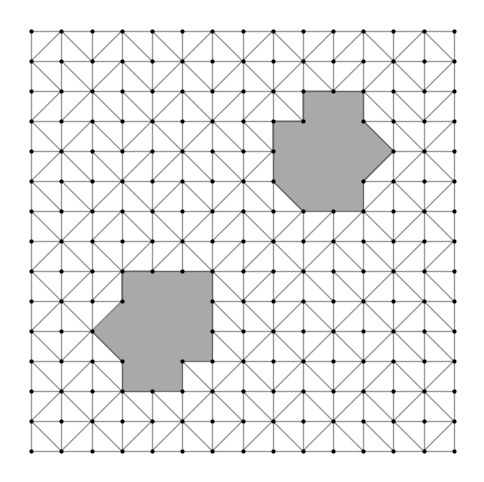

In [3]:
n_side, point_gen_mode = 15, 0

r1, r2 = 0.6, 0.2
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)

pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
plt.figure(figsize=(6,6))
SC.plot()

In [4]:
#plot_bases(SC)

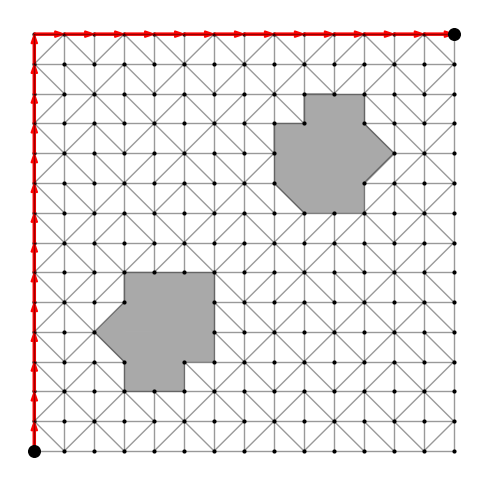

In [5]:
ref_path_coords = [(-1,-1), (-1, 1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC, True)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'ref')

In [6]:
ref_path.edge_projections[-1]

array([ 0.77791406,  0.74780658, -0.30104805, -1.0252333 , -1.06202868,
       -1.0436964 ,  0.01057491, -0.86274778,  0.14612938,  0.11279033,
        0.54854701, -0.56545366])

Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [ 3.67389298e-02 -8.55975200e-07  2.19037323e-02 -8.89439213e-04
 -5.99216807e-03 -5.33070934e-04  8.14032178e-04 -8.71123087e-04
 -5.56472361e-03  6.49899296e-03 -1.52669501e-03 -3.39190317e-02]
Proj: [ 1.91748751e-02 -8.67458501e-06  9.69126566e-03 -3.24088463e-04
 -9.66547718e-03 -6.94679499e-05 -9.28578705e-03 -3.19577995e-04
 -1.93833173e-03  1.73390812e-03 -2.83694820e-04 -1.07897860e-02]
Proj: [-2.58143295e-02  1.52766731e-07 -2.25565765e-02  6.67191587e-04
 -2.57976079e-02  6.68537989e-04 -4.38882684e-02  6.27727180e-04
  4.20324884e-03 -6.00968220e-03  1.65139554e-03  2.6890

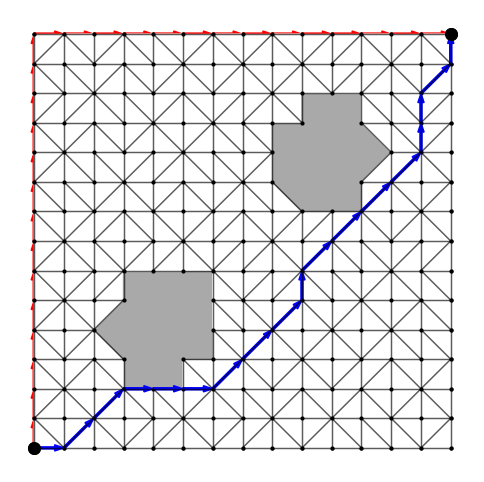

alpha = 0.0, final cost = 3.1631622319615635, ref cost = 4.0, path cost = 3.1631622319615644
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [-0.88019607 -0.65019094 -0.30104805 -0.35733121 -1.06202868  0.52189497
  0.01057491 -0.34996515  0.20485265  0.09712132  0.00298303 -0.52203718]
proj diff: 8.167060815381753
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975200e

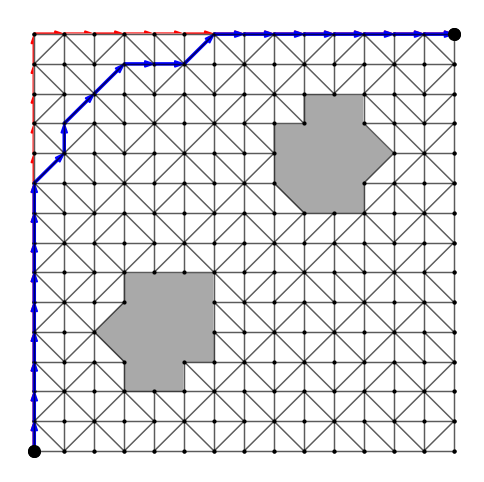

alpha = 0.1, final cost = 3.717672892784625, ref cost = 4.0, path cost = 3.7176727994910563
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.88654422 -1.06202868 -0.87978953
  0.01057491 -0.4964798   0.0014336   0.19833788  0.09292391 -0.89405532]
proj diff: 0.5240790670643036
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975200e

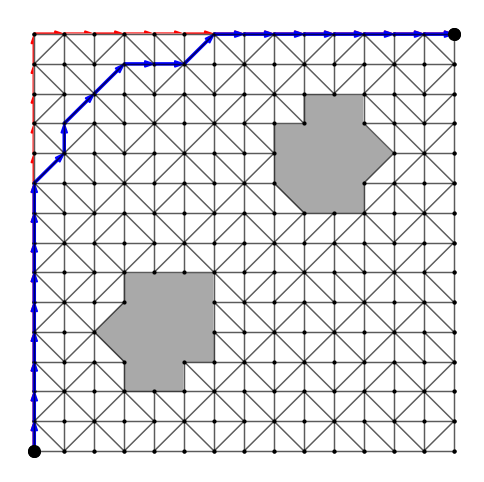

alpha = 0.2, final cost = 3.7700808927846254, ref cost = 4.0, path cost = 3.7700807061974864
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.88654422 -1.06202868 -0.87978953
  0.01057491 -0.4964798   0.0014336   0.19833788  0.09292391 -0.89405532]
proj diff: 0.5240790670643036
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975200

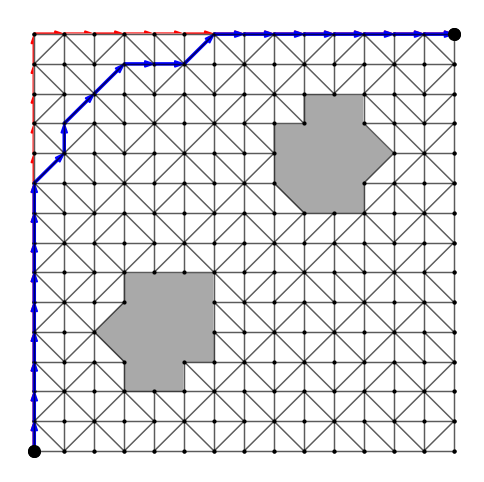

alpha = 0.30000000000000004, final cost = 3.8224888927846257, ref cost = 4.0, path cost = 3.822488612903917
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.88654422 -1.06202868 -0.87978953
  0.01057491 -0.4964798   0.0014336   0.19833788  0.09292391 -0.89405532]
proj diff: 0.5240790670643036
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e

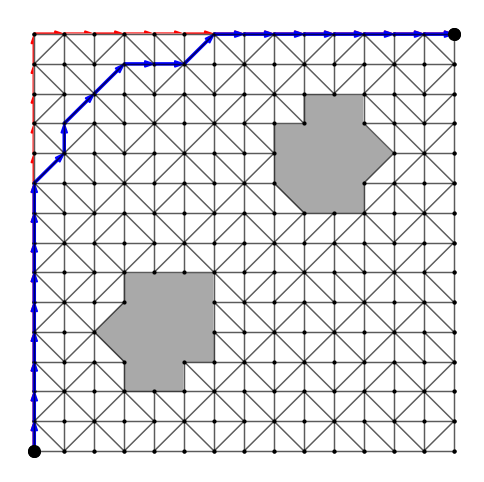

alpha = 0.4, final cost = 3.8748968927846255, ref cost = 4.0, path cost = 3.8748965196103473
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.88654422 -1.06202868 -0.87978953
  0.01057491 -0.4964798   0.0014336   0.19833788  0.09292391 -0.89405532]
proj diff: 0.5240790670643036
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975200

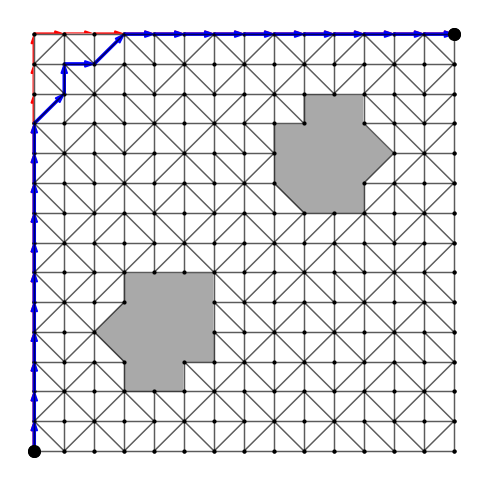

alpha = 0.5, final cost = 3.8552374463923127, ref cost = 4.0, path cost = 3.8552386403154704
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.99432247 -1.06202868 -1.00657267
  0.01057491 -0.76539094  0.11160446  0.12690911  0.41463557 -0.68409934]
proj diff: 0.04521238784631564
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.5597520

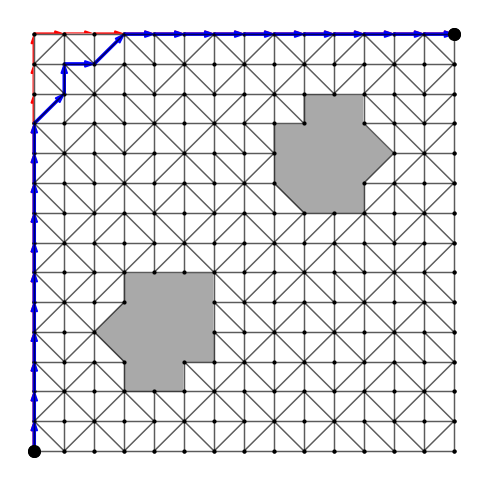

alpha = 0.6000000000000001, final cost = 3.8597584463923127, ref cost = 4.0, path cost = 3.859759879100102
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.99432247 -1.06202868 -1.00657267
  0.01057491 -0.76539094  0.11160446  0.12690911  0.41463557 -0.68409934]
proj diff: 0.04521238784631564
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e

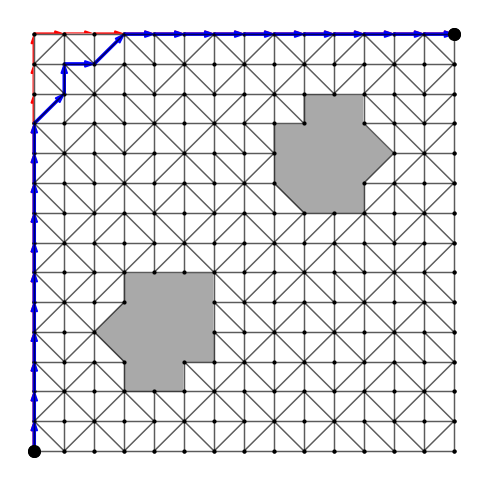

alpha = 0.7000000000000001, final cost = 3.8642794463923127, ref cost = 4.0, path cost = 3.8642811178847336
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.99432247 -1.06202868 -1.00657267
  0.01057491 -0.76539094  0.11160446  0.12690911  0.41463557 -0.68409934]
proj diff: 0.04521238784631564
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298

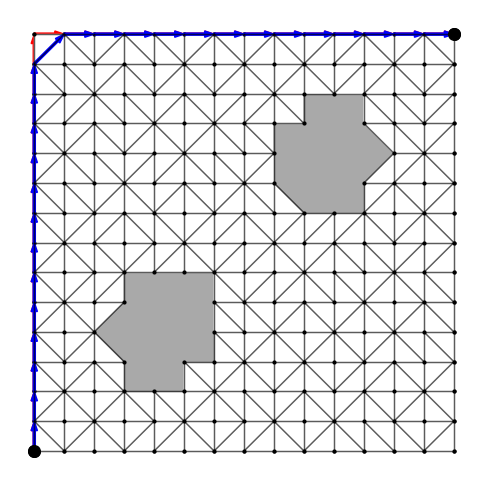

alpha = 0.8, final cost = 3.916412223196156, ref cost = 4.0, path cost = 3.9164147703732706
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -1.0238022  -1.06202868 -1.04196436
  0.01057491 -0.85786792  0.14438207  0.11349266  0.54156294 -0.57193435]
proj diff: 0.00012318397139217342
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975

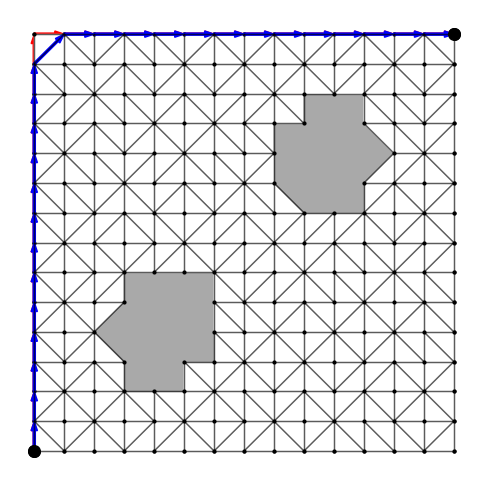

alpha = 0.9, final cost = 3.916424223196156, ref cost = 4.0, path cost = 3.91642708877041
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -1.0238022  -1.06202868 -1.04196436
  0.01057491 -0.85786792  0.14438207  0.11349266  0.54156294 -0.57193435]
proj diff: 0.00012318397139217342
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.5597520

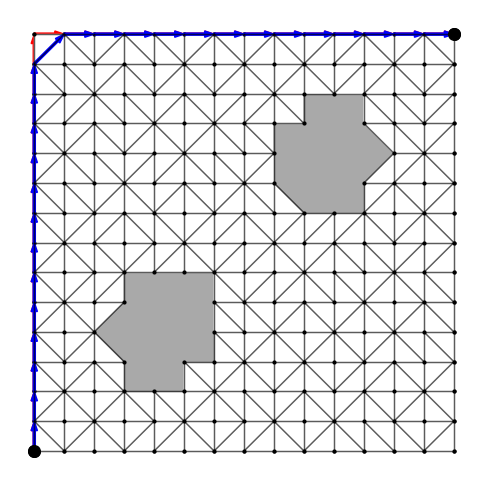

alpha = 1.0, final cost = 3.916436223196156, ref cost = 4.0, path cost = 3.916439407167549
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -1.0238022  -1.06202868 -1.04196436
  0.01057491 -0.85786792  0.14438207  0.11349266  0.54156294 -0.57193435]
proj diff: 0.00012318397139217342
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.559752

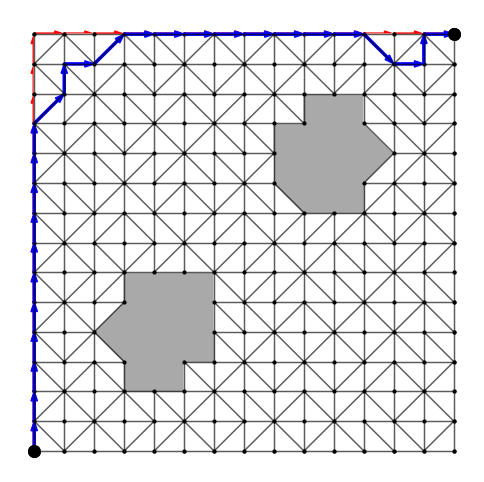

alpha = 100.0, final cost = 8.111662955302755, ref cost = 4.0, path cost = 8.112120623222415
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.99404707 -1.06202868 -1.00662584
  0.01057491 -0.76555927  0.10646606  0.12624112  0.41515819 -0.66259007]
proj diff: 0.0407745766791966
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Proj: [-1.83694649e-02  4.27987600e-07 -1.56623871e-02  4.59004185e-04
 -1.54112754e-02  2.76252873e-04 -2.79031108e-02  4.69193232e-04
  3.02097008e-03 -3.52919090e-03  8.39466980e-04  1.90348049e-02]
Proj: [ 1.83694649e-02 -4.27987600e-07  6.24134524e-03 -4.59004185e-04
 -2.14034435e-02 -2.76252873e-04 -2.70890786e-02 -4.69193232e-04
 -3.02097008e-03  3.52919090e-03 -8.39466980e-04 -1.90348049e-02]
Proj: [-3.67389298e-02  8.55975200

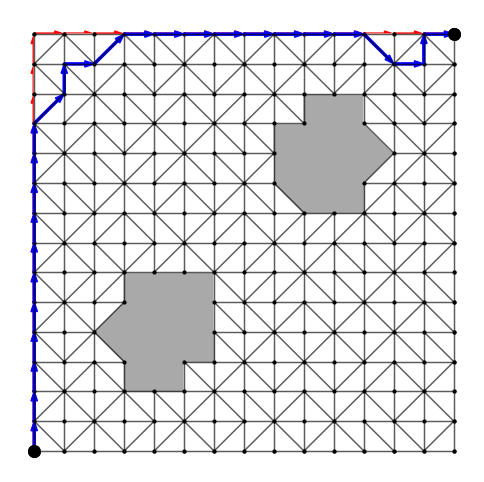

alpha = 1000.0, final cost = 44.80466295530276, ref cost = 4.0, path cost = 44.809239634499356
ref proj : [ 0.77791406  0.74780658 -0.30104805 -1.0252333  -1.06202868 -1.0436964
  0.01057491 -0.86274778  0.14612938  0.11279033  0.54854701 -0.56545366], path proj : [ 0.77791406  0.74780658 -0.30104805 -0.99404707 -1.06202868 -1.00662584
  0.01057491 -0.76555927  0.10646606  0.12624112  0.41515819 -0.66259007]
proj diff: 0.0407745766791966
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [5]:
start, end = 0, len(SC.node_vec)-1
alphas = np.arange(0, 1.1, 0.1)
alphas = np.hstack([alphas, [100, 1000]])

path_interp_experiment(SC, start, end, ref_path, alphas, False, True)

# Example 2

In [8]:
n_side, point_gen_mode = 15, 0

r1, r2 = 0.6, 0.2
n_holes = 4
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)

(14, 506)


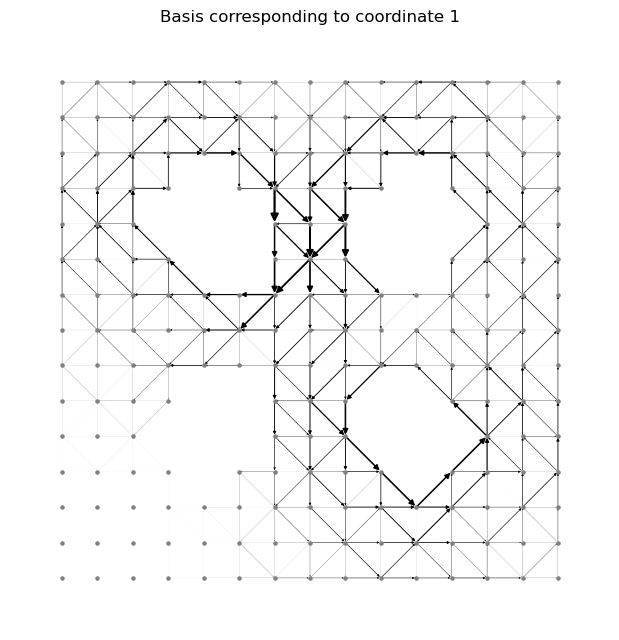

(14, 506)


/Users/ctaveras/opt/anaconda3/envs/ot-simp/lib/python3.9/site-packages/matplotlib/patches.py:3391: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


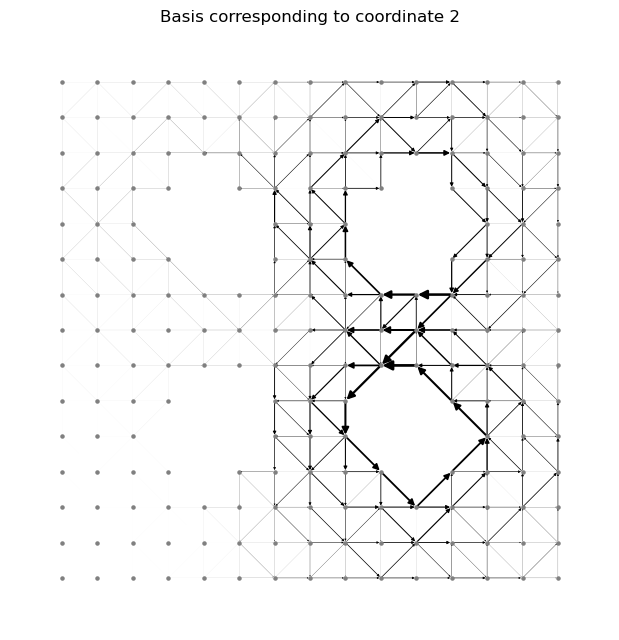

(14, 506)


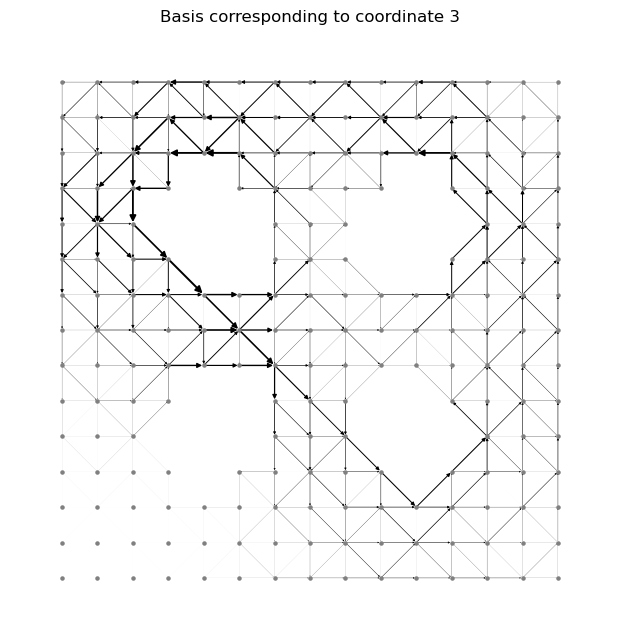

(14, 506)


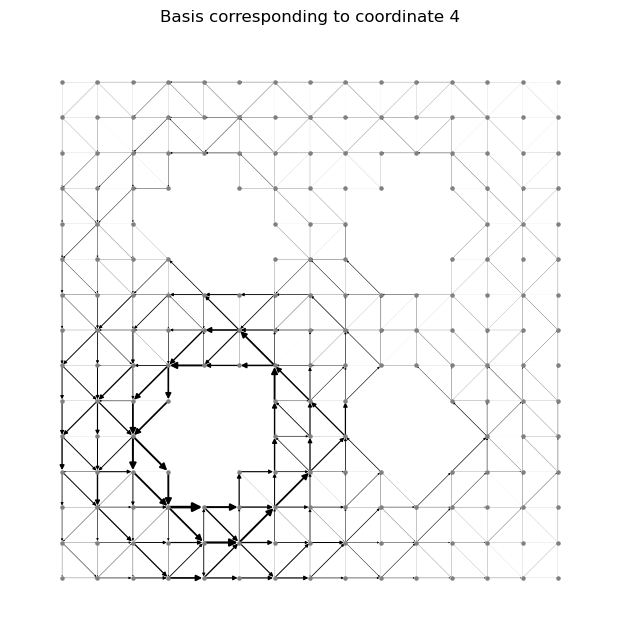

(14, 506)


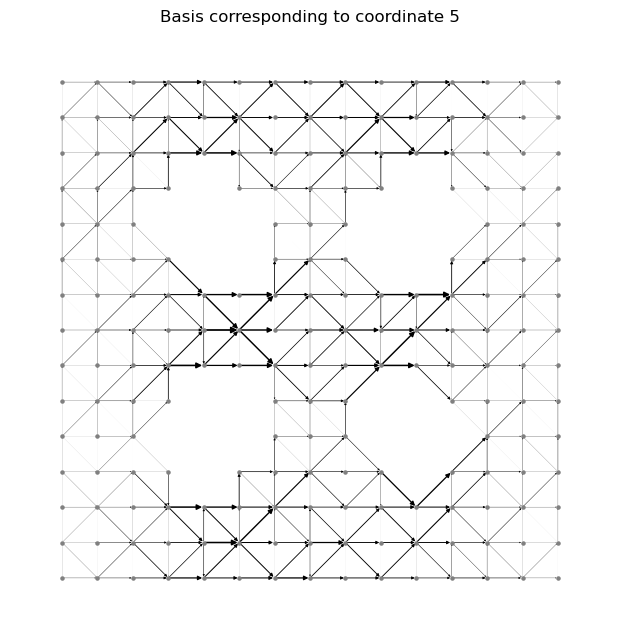

(14, 506)


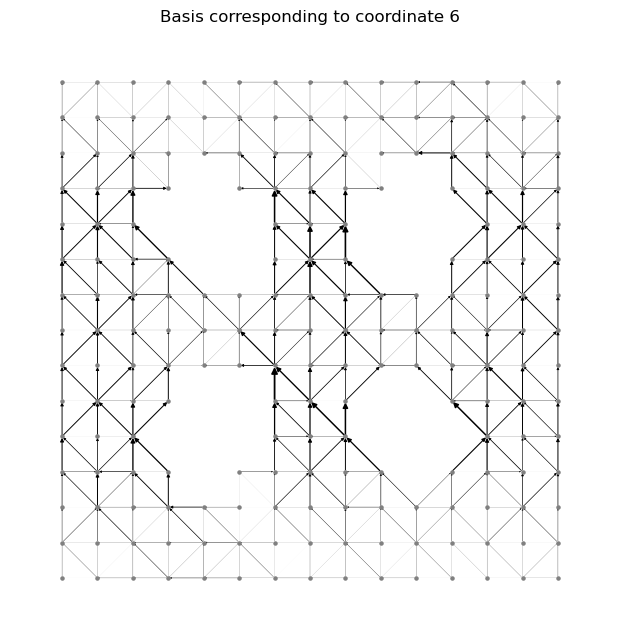

(14, 506)


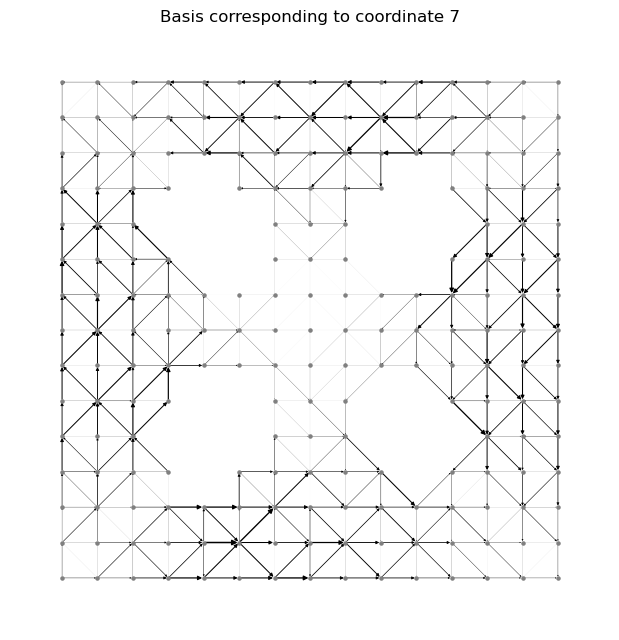

(14, 506)


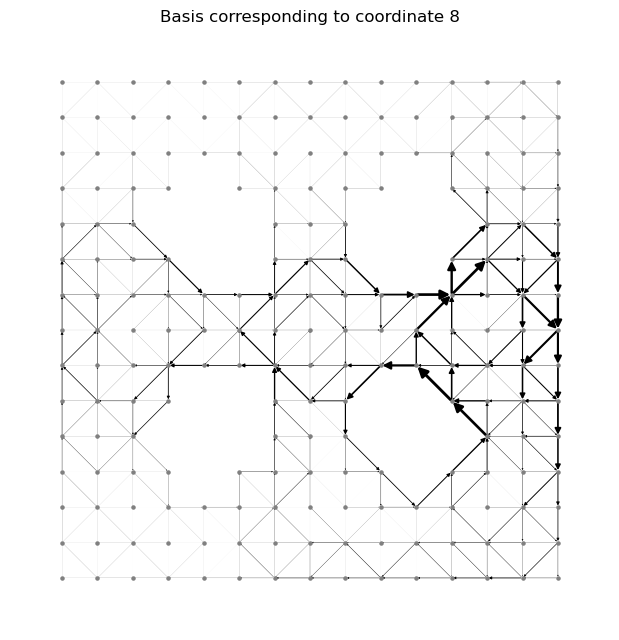

(14, 506)


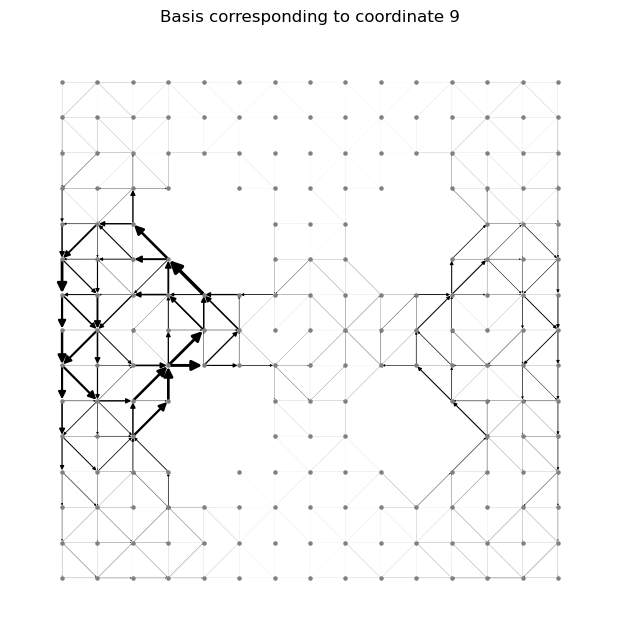

(14, 506)


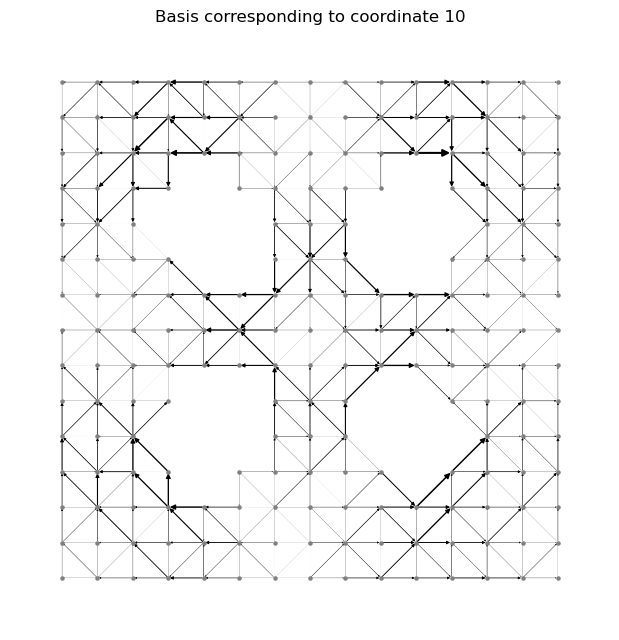

(14, 506)


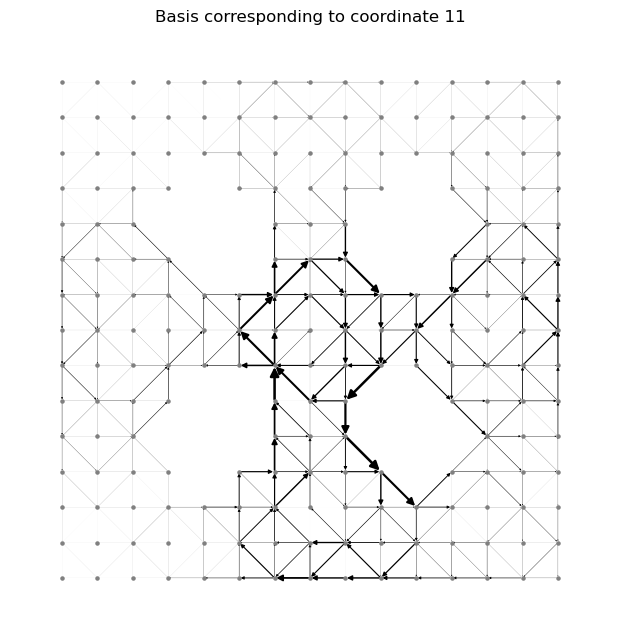

(14, 506)


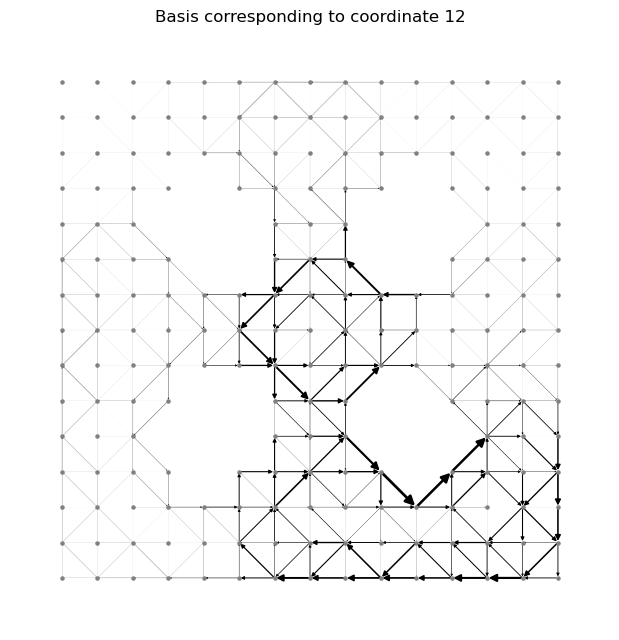

(14, 506)


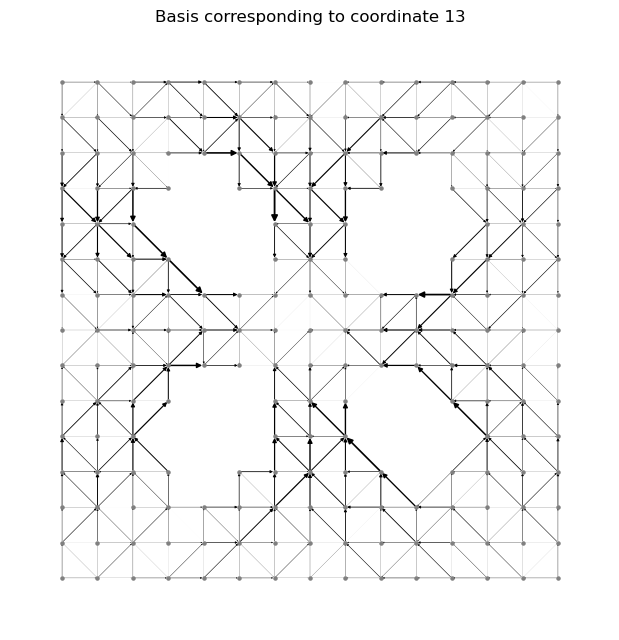

(14, 506)


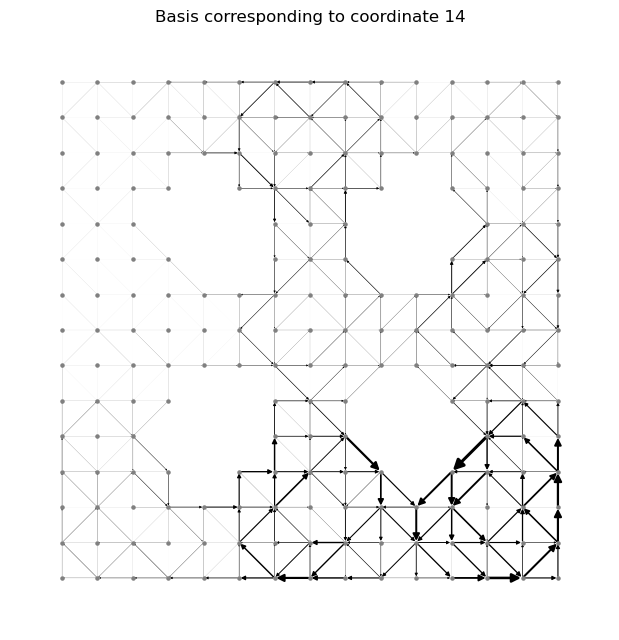

In [9]:
plot_bases(SC)

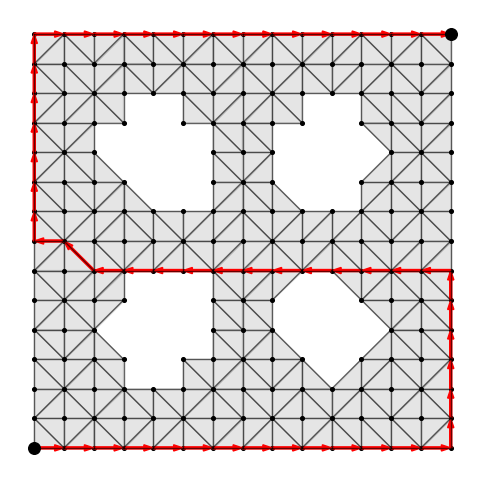

In [10]:
ref_path_coords = [(-1,-1), (1, -1), (1,-0.1), (-0.1,-0.1), (-1, 0), (-1,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC, True)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'ref')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr cost = inf, new cost : 0.1428571428571428
curr proj diff = inf, new proj diff = 13.07629
neighbor position = [-0.85714286 -1.        ]
Proj: [ 1.63234878e-09 -7.44926822e-17 -2.00530539e-16 -1.78397581e-02
  6.58498664e-03  1.79341241e-02  2.37888078e-02  3.87024507e-03
 -1.23223235e-02  1.87396042e-02 -1.26172338e-03  6.45404439e-03
  2.60700048e-02  1.41839950e-02]
curr neighbor = 15, curr cost = inf, new cost : 0.1428571428571428
curr proj diff = inf, new proj diff = 13.11839
neighbor position = [-1.         -0.85714286]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 1 with cost 0.14285

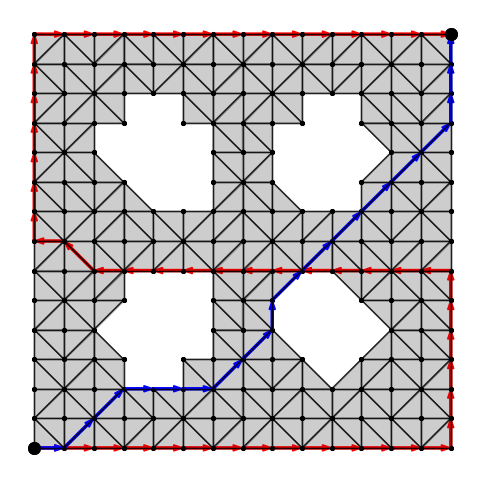

alpha = 0.0, final cost = 3.1631622319615644, ref cost = 7.916316223196156, path cost = 3.1631622319615644
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [-0.08061313 -0.99466968  0.24276714  0.88982762  0.94702098  0.58210697
 -0.00434292  0.15749652  0.22064013  0.08984622 -0.36316514  0.56434406
 -0.00301553  0.37900255]
proj diff: 18.668220148674244
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, cur

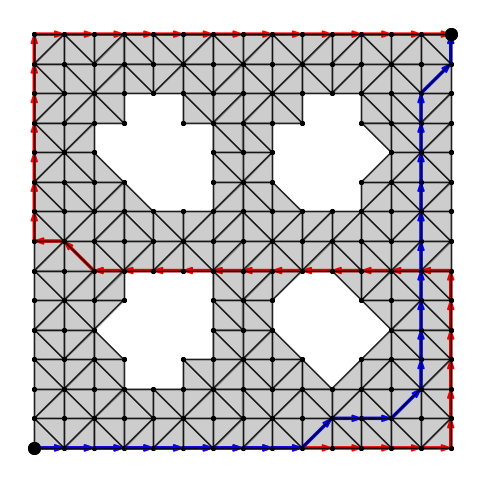

alpha = 0.1, final cost = 4.646963669588469, ref cost = 7.916316223196156, path cost = 4.646963264280664
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 0.78945073  0.32225993  0.66763538  0.89336127  0.94702098  0.58210697
 -0.00434292 -0.88588821 -0.23029915  0.08984622 -0.34749109 -1.00925661
 -0.00301553 -0.43645018]
proj diff: 8.980145946921951
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr c

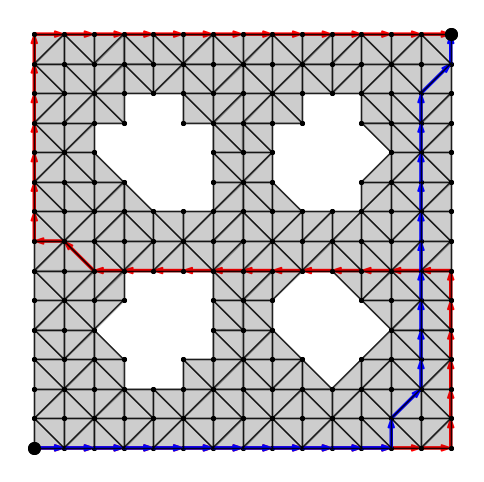

alpha = 0.2, final cost = 5.542074446392313, ref cost = 7.916316223196156, path cost = 5.542074718131076
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 0.78945073  0.32225993  0.66763538  0.89336127  0.94702098  0.58210697
 -0.00434292 -0.93403854 -0.24795964  0.08984622 -0.41567509 -1.17429653
 -0.00301553 -0.31349528]
proj diff: 8.54721135869381
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr co

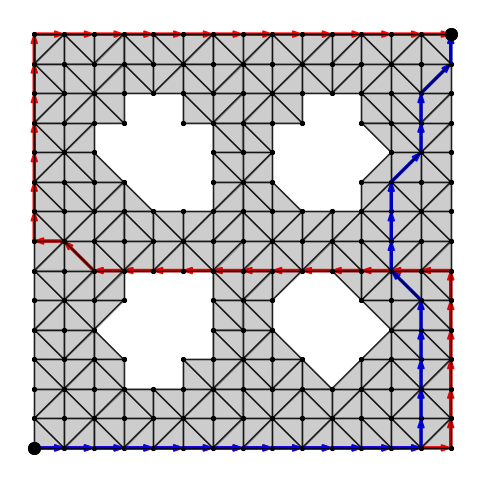

alpha = 0.30000000000000004, final cost = 6.3301549553027545, ref cost = 7.916316223196156, path cost = 6.330155319287831
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 0.78945073  0.32225993  0.66763538  0.89336127  0.94702098  0.58210697
 -0.00434292 -0.43573744 -0.03079144  0.08984622 -0.78304436 -1.34430379
 -0.00301553  0.07469848]
proj diff: 7.651641213283586
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr nei

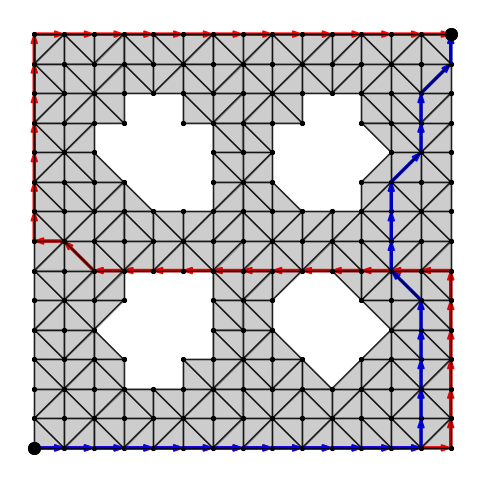

alpha = 0.4, final cost = 7.095318955302755, ref cost = 7.916316223196156, path cost = 7.09531944061619
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 0.78945073  0.32225993  0.66763538  0.89336127  0.94702098  0.58210697
 -0.00434292 -0.43573744 -0.03079144  0.08984622 -0.78304436 -1.34430379
 -0.00301553  0.07469848]
proj diff: 7.651641213283586
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr co

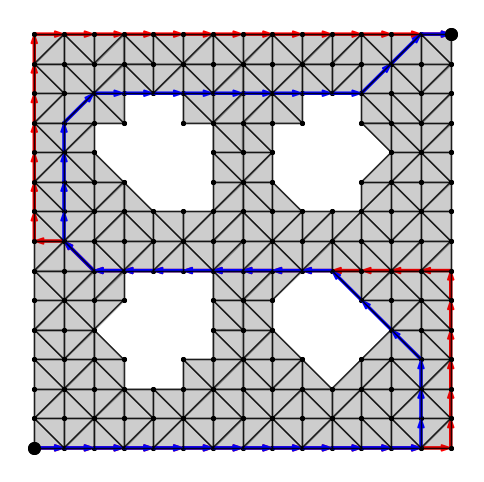

alpha = 0.5, final cost = 7.316909990944523, ref cost = 7.916316223196156, path cost = 7.316911482543528
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.69190072 -0.61450777  0.08984622 -0.73895375 -1.6373633
 -0.00301553  0.04377   ]
proj diff: 0.948252983198006
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr co

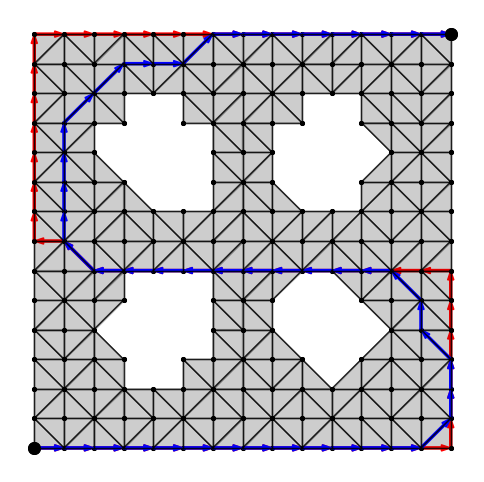

alpha = 0.6000000000000001, final cost = 7.238647276658808, ref cost = 7.916316223196156, path cost = 7.238646839997561
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.31245265 -0.81497241  0.08984622 -0.53329446 -2.11572987
 -0.00301553  0.13063146]
proj diff: 0.1835792722312544
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neig

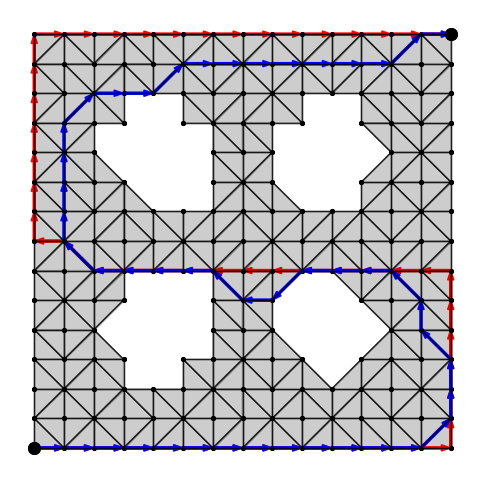

alpha = 0.7000000000000001, final cost = 7.410324008765409, ref cost = 7.916316223196156, path cost = 7.410323146674363
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.39661475 -0.82973264  0.08984622 -0.33952492 -2.21441089
 -0.00301553  0.25221464]
proj diff: 0.23353876844136587
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr nei

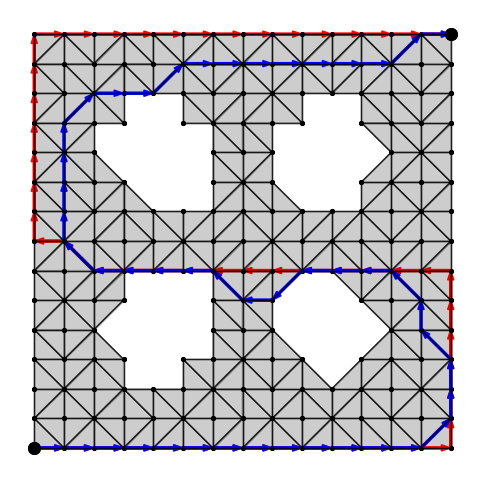

alpha = 0.8, final cost = 7.433678008765409, ref cost = 7.916316223196156, path cost = 7.4336770235185
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.39661475 -0.82973264  0.08984622 -0.33952492 -2.21441089
 -0.00301553  0.25221464]
proj diff: 0.23353876844136587
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr c

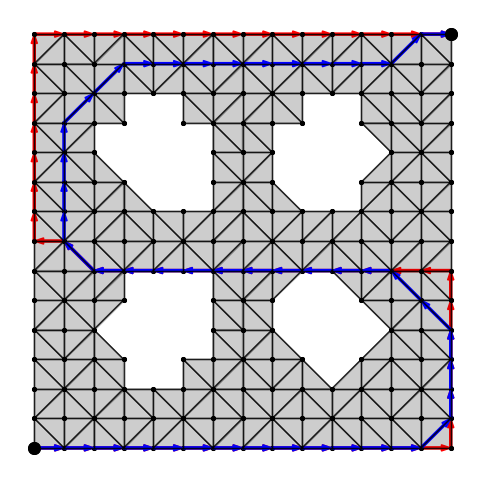

alpha = 0.9, final cost = 7.293397276658809, ref cost = 7.916316223196156, path cost = 7.293392981173581
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.23202108 -0.84049444  0.08984622 -0.54470093 -2.10554811
 -0.00301553  0.32126384]
proj diff: 0.18321522723863523
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr

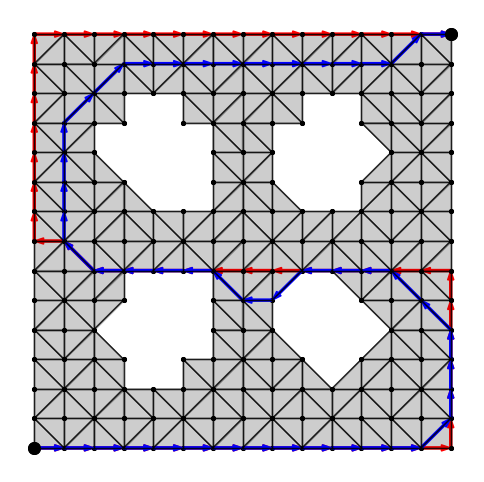

alpha = 1.0, final cost = 7.466736008765408, ref cost = 7.916316223196156, path cost = 7.466735989526541
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.35113493 -0.85873922  0.08984622 -0.32360008 -2.26484509
 -0.00301553  0.29487202]
proj diff: 0.21988998076113322
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, curr

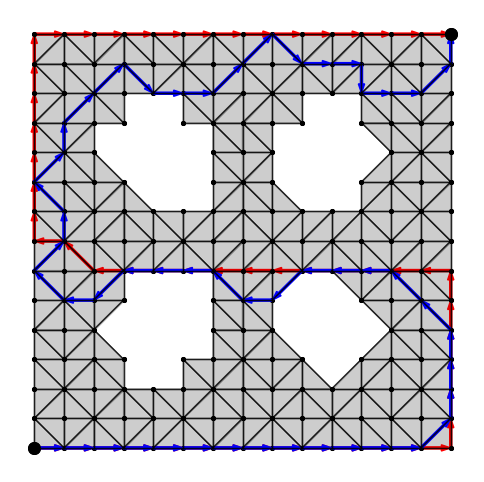

alpha = 100.0, final cost = 19.59366150862037, ref cost = 7.916316223196156, path cost = 19.594138936115584
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.44543705 -1.39370885  0.08984622 -0.42248793 -2.15340637
 -0.00301553  0.31327808]
proj diff: 0.1130247742749521
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
visiting 0 with cost 0
node position = [-1. -1.]
Proj: [-1.63234886e-09  0.00000000e+00 -2.59726851e-21  1.78397581e-02
  1.96611093e-02 -5.68582085e-04  2.62562318e-02 -3.87024507e-03
  1.23223235e-02 -1.04715262e-02  1.26172338e-03 -6.45404439e-03
  1.69013291e-02 -1.41839950e-02]
curr neighbor = 1, cu

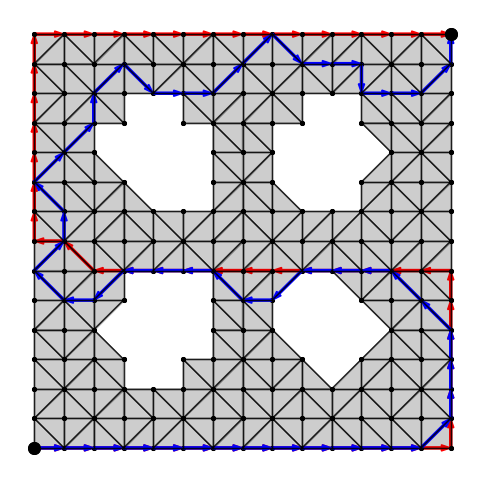

alpha = 1000.0, final cost = 112.78166150862037, ref cost = 7.916316223196156, path cost = 112.78019104225842
ref proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.21998576 -1.22821705  0.08984622 -0.52024137 -2.17451346
 -0.00301553  0.15577346], path proj : [ 1.02663546  1.3027323  -1.33366939  0.88110941  0.94702098  0.58210697
 -0.00434292  0.43795175 -1.36841909  0.08984622 -0.41623326 -2.15638882
 -0.00301553  0.31756516]
proj diff: 0.10448852953363805
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [11]:
start, end = 0, len(SC.node_vec)-1
alphas = np.arange(0, 1.1, 0.1)
alphas = np.hstack([alphas, [100, 1000]])
extra = True
verbose = True

path_interp_experiment(SC, start, end, ref_path, alphas, verbose, extra)

# Question: 
Is there a principled way to get flow vectors whose flow is in some sense localized? 
The harmonic vector provides us with the global information necessary to steer a path towards 
the right homotopy type. Localized flows in the complex should be able to help with the fine tuning 
of the path.

Observation: 
As the algorithm is greedy, arbitrarily increasing the dependence of the cost on 
the regularization term can lead to undesirable paths. 